# Charge Carrier Trapping Experiment

CCT = Charge Carrier Trapping - This is a test of comparing the Zhou et al 2017 results with a data driven analysis using multinest

In [1]:
%matplotlib inline
from pylab  import *;ion()
from pandas import read_csv, DataFrame, concat
from time   import time

from exoparams import PlanetParams
from astropy import units as u

In [2]:
test_data = read_csv('test_data.dat')
test_data

,DeltaPhase,DeltaTimes,Flux,OrbitNumber,Sigma
0,0.000000,0.000000,0.999005,1.0,0.000105
1,0.000496,0.002303,0.999144,1.0,0.000105
2,0.000993,0.004607,0.999294,1.0,0.000105
3,0.001489,0.006910,0.999633,1.0,0.000105
4,0.001985,0.009213,0.999547,1.0,0.000105
5,0.002482,0.011516,0.999642,1.0,0.000105
6,0.002978,0.013820,0.999737,1.0,0.000105
7,0.003474,0.016123,0.999966,1.0,0.000105
8,0.003971,0.018426,1.000034,1.0,0.000105
9,0.004467,0.020729,0.999950,1.0,0.000105


**Check if the data makes sense as is**

<Container object of 3 artists>

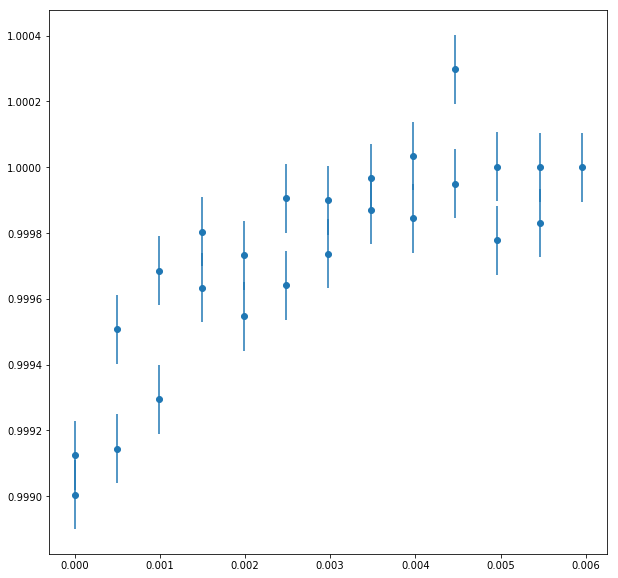

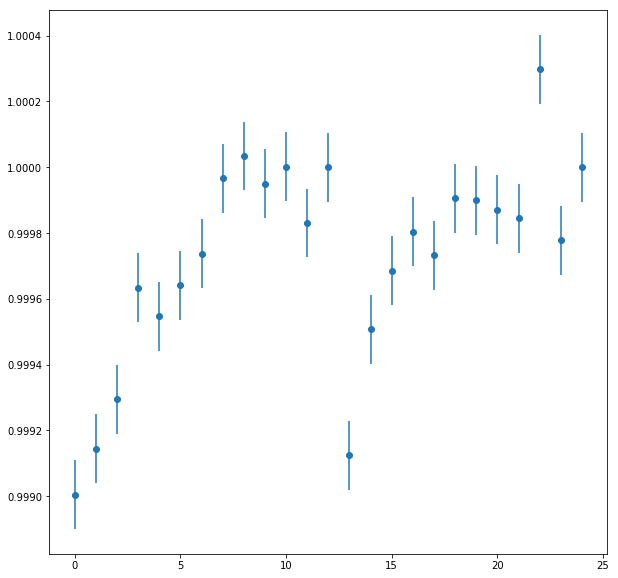

In [3]:
fig = figure(figsize=(10,10))
errorbar(test_data['DeltaPhase'], test_data['Flux'] , test_data['Sigma'], fmt='o')

fig = figure(figsize=(10,10))
errorbar(np.arange(test_data['DeltaPhase'].size), test_data['Flux'] , test_data['Sigma'], fmt='o')
# errorbar(h38_v2_orbitPhased['DeltaPhase'], h38_v2_orbitPhased['Flux'] , h38_v2_orbitPhased['Sigma'], fmt='o')
# errorbar(w67_v1_orbitPhased['DeltaPhase'], w67_v1_orbitPhased['Flux'] , w67_v1_orbitPhased['Sigma'], fmt='o')

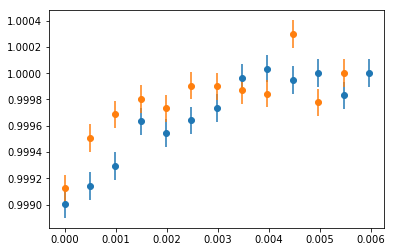

In [4]:
for k in test_data['OrbitNumber'].unique():
    orbitNNow = test_data['OrbitNumber'] == k
    errorbar(test_data['DeltaPhase'][orbitNNow]    , \
             test_data['Flux'][orbitNNow]          , \
             test_data['Sigma'][orbitNNow], fmt='o')

In [5]:
def zhou_model(params):
    # Zhou et al. 2017
    # The exponential ramp timescale is detector dependennt, and therfore uniform across all observations
    # But the difference from orbit to orbit is predicted to be related 
    #   ONLY to the inital number of charge traps populated at the start of the each ramp
    
    # BIG ASSUMPTION
    
    flux    = ydata.copy() # I assume that what Zhou means by `flux` is either the WLC or avg WLC value
    # flux    = ydata.copy() / 128 # I assume that what Zhou means by `flux` is either the WLC or avg WLC value
    
    E0fast  = params[0] # Orbit 0; Start with per frame; may want per pixel
    E0slow  = params[1] # Orbit 0; Start with per frame; may want per pixel
    
    # Separate out the delta-E0 components per orbit
    # Keep dE0fast[0] and dE0slow[0] == 0.0 because they correspond to E0fast and E0slow (initial)
    dE0fast     = np.zeros(nOrbits)
    dE0slow     = np.zeros(nOrbits)
    for k in range(1, nOrbits):
        print(k,2*k, 2*k+1,len(params))
        dE0fast[k] = params[2*k]
        dE0slow[k] = params[2*k+1]
    
    # From Table 3 of Zhou et al. 2017
    ETotFast  = 270.6
    etaFast   = 0.006863
    tauFast   = 224.8
    
    ETotSlow  = 1320.0
    etaSlow   = 0.01311
    tauSlow   = 2.45e4
    
    coeffFast0= (etaFast * flux / ETotFast + tauFast**-1)
    coeffSlow0= (etaSlow * flux / ETotSlow + tauSlow**-1)
    
    coeffFast1= etaFast*flux / coeffFast0
    coeffSlow1= etaSlow*flux / coeffSlow0
    
    Efast     = zeros(orbit_phase.shape)
    Eslow     = zeros(orbit_phase.shape)
    for k in range(nOrbits):
        orbitNow         = where(orbitNumber == k)[0]
        Efast[orbitNow]  = coeffFast1 + (E0fast + dE0fast[k] - coeffFast1)*exp(-coeffFast0 * tphase[orbitNow])
        Eslow[orbitNow]  = coeffSlow1 + (E0slow + dE0slow[k] - coeffSlow1)*exp(-coeffSlow0 * tphase[orbitNow])
    
    dEFastDtP = etaFast * flux * (ETotFast - Efast) / ETotFast
    dEFastDtN = -Efast / tauFast
    
    dESlowDtP = etaSlow * flux * (ETotSlow - Eslow) / ETotSlow
    dESlowDtN = -Eslow / tauSlow
    
    lambda phase: 1 - dEFastDtP - dESlowDtP - dEFastDtP - dESlowDtP

# PyMultiNest Demo

In [6]:
from __future__ import absolute_import, unicode_literals, print_function
import pymultinest
import math
import os
import threading, subprocess
from sys import platform

if not os.path.exists("chains"): os.mkdir("chains")
    

In [7]:
%matplotlib inline
from pylab import *;ion()

# from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def single_exponential_model(cube):
    alpha = cube[0]
    beta  = cube[1]
    gamma = cube[2]
    
    return lambda xdata: alpha - beta*exp(-gamma*xdata)

def double_exponential_model(cube):
    alpha   = cube[0]
    beta    = cube[1]
    gamma   = cube[2]
    delta   = cube[3]
    epsilon = cube[4]
    
    return lambda xdata: alpha - beta*exp(-gamma*xdata) - delta*exp(-epsilon*xdata)

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

** Generate Fake Data for Algorithm Testing **

<Container object of 3 artists>

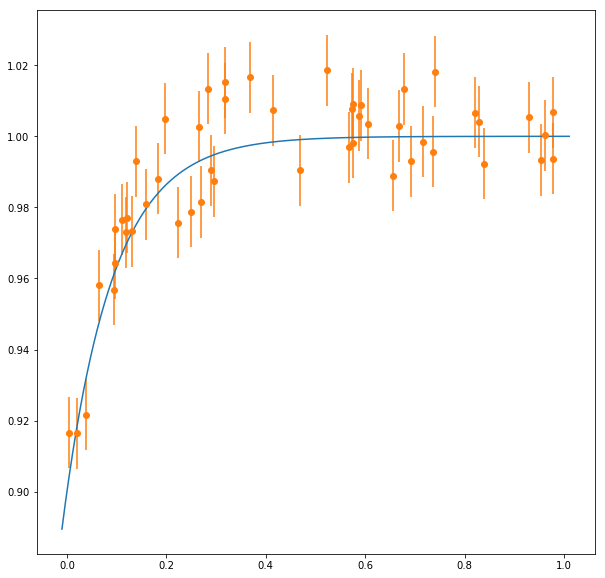

In [8]:
np.random.seed(0)

param0_test= 1#0.05
param1_test= .1#5*pi
param2_test= 10.0
yunc_test  = 0.01
nPts_test  = int(50)
nThPts_test= int(1e3)

xmin_test  = -0.0#*pi
xmax_test  =  1.0#*pi
dx_test    = 0.01*(xmax_test - xmin_test)

model_test = single_exponential_model
# model_test = sine_wave
# model_test = straight_line

yuncs_test = np.random.normal(yunc_test, 1e-2 * yunc_test, nPts_test)
thdata_test= np.linspace(xmin_test-dx_test, xmax_test+dx_test, nThPts_test)

xdata_test = np.random.uniform(xmin_test, xmax_test, nPts_test)
xdata_test = sort(xdata_test)

ydata_test = model_test([param0_test,param1_test,param2_test])(xdata_test)

yerr_test  = np.random.normal(0, yuncs_test, nPts_test)
zdata_test = ydata_test + yerr_test

figure(figsize=(10,10))
plot(thdata_test, model_test([param0_test,param1_test,param2_test])(thdata_test))
errorbar(xdata_test, zdata_test, yunc_test*ones(zdata_test.size), fmt='o')

# Single Exponential Model

1.0 0.00129283097155 839.0


<Container object of 3 artists>

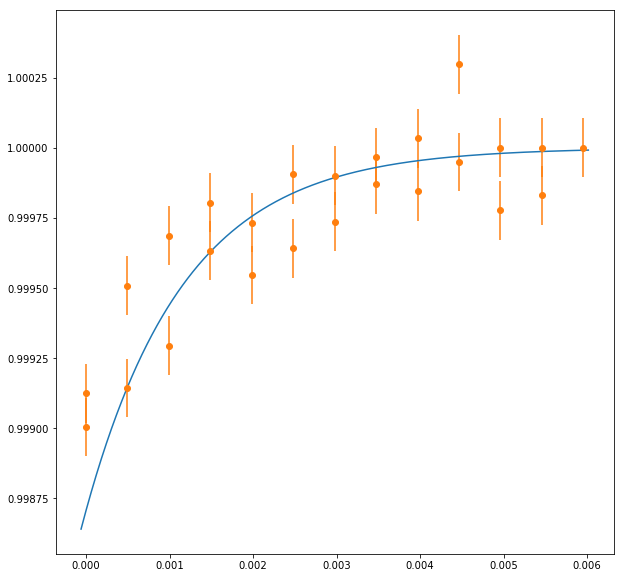

In [9]:
nThPts    = int(1e3)
model_SEM = single_exponential_model

xdata = test_data['DeltaPhase']
ydata = test_data['Flux']
yuncs = test_data['Sigma']

xmin, xmax = xdata.min(), xdata.max()
dx         = (xmax - xmin)/100
thdata_SEM = np.linspace(xmin-dx, xmax+dx, nThPts)

param0_SEM_init= 1.0  # by defintion
param1_SEM_init= (ydata.max() - ydata.min())#/100
param2_SEM_init= round(5/(xdata.max() - xdata.min()))

print(param0_SEM_init, param1_SEM_init, param2_SEM_init)

figure(figsize=(10,10))
plot(thdata_SEM, model_SEM([param0_SEM_init,param1_SEM_init,param2_SEM_init])(thdata_SEM))
errorbar(xdata, ydata, yuncs, fmt='o')

In [10]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave
# parameters = ["amp", "period"]

# model = straight_line
# parameters = ["offset", "slope"]

model_SEM       = single_exponential_model
parameters_SEM  = ['max', 'amp1', 'scale1']

def myprior_SEM(cube, ndim, nparams):
    cube0_width = 1e-3
    cube[0] = cube[0] * cube0_width  + (1 - 0.5*cube0_width)# - 10# U(0,2)
    cube[1] = cube[1] # - 10# U(0,1) -- default
    cube[2] = cube[2] * 1e4   - 5e3# - 1000 # U(0,2000)

def myloglike_SEM(cube, ndim, nparams):
    chi = 1.
    # print "cube", [cube[i] for i in range(ndim)], cube
    # for i in range(ndim):
    #     chi *= -0.5 * ((cube[i] - 0.2) / 0.1)**2#math.cos(cube[i] / 2.) * math.sin(cube[i] / 2.)
    # print "returning", math.pow(2. + chi, 5)
    modelNow = model_SEM(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

SEM took 46.35731482505798 seconds
  analysing data from chains/HAT38-visit1-single_exponential_model-.txt


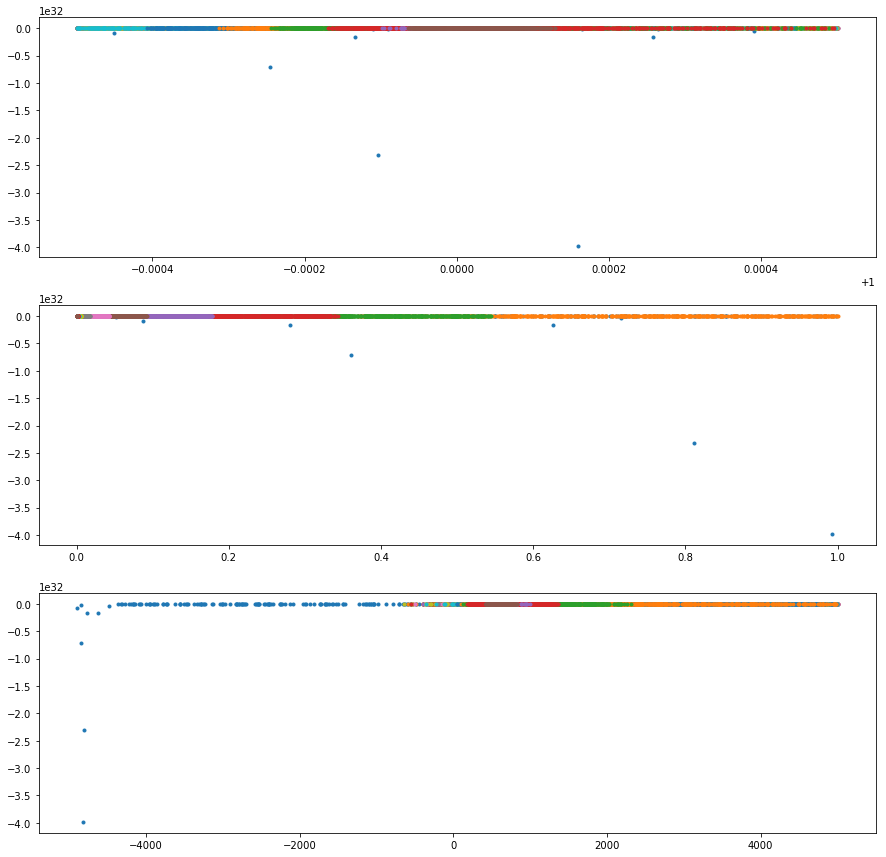

In [11]:
# number of dimensions our problem has
# parameters = ["x", "y"]
n_params_SEM = len(parameters_SEM)

planetName           = 'HAT38'
visitName            = 'visit1'
modelName            = 'single_exponential_model'
outputfiles_basename = 'chains/' + planetName + '-' + visitName + '-' + modelName + '-'

start = time()

plt.figure(figsize=(5*n_params_SEM, 5*n_params_SEM))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params_SEM, outputfiles_basename=outputfiles_basename); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike_SEM, myprior_SEM, n_params_SEM, \
                importance_nested_sampling = False, resume = False, verbose = True, \
                sampling_efficiency = 'model', n_live_points = 1000, outputfiles_basename=outputfiles_basename);

# ok, done. Stop our progress watcher
progress.stop();
print('SEM took', time() - start, 'seconds')
# lets analyse the results
a_SEM = pymultinest.Analyzer(n_params = n_params_SEM, outputfiles_basename=outputfiles_basename);
s_SEM = a_SEM.get_stats();

In [12]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a_SEM.outputfiles_basename, 'w') as f:
    json.dump(parameters_SEM, f, indent=2)
# store derived stats
with open('%sstats.json' % a_SEM.outputfiles_basename, mode='w') as f:
    json.dump(s_SEM, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\t%.15e +- %.15e" % ( s_SEM['nested sampling global log-evidence'], \
                                             s_SEM['nested sampling global log-evidence error'] ))
print("Global Evidence:\t%.3f +- %.3f" % ( s_SEM['nested sampling global log-evidence'], \
                                             s_SEM['nested sampling global log-evidence error'] ))


------------------------------ ANALYSIS ------------------------------
Global Evidence:	-3.648569459714431e+01 +- 1.164073854566224e-01
Global Evidence:	-36.486 +- 0.116


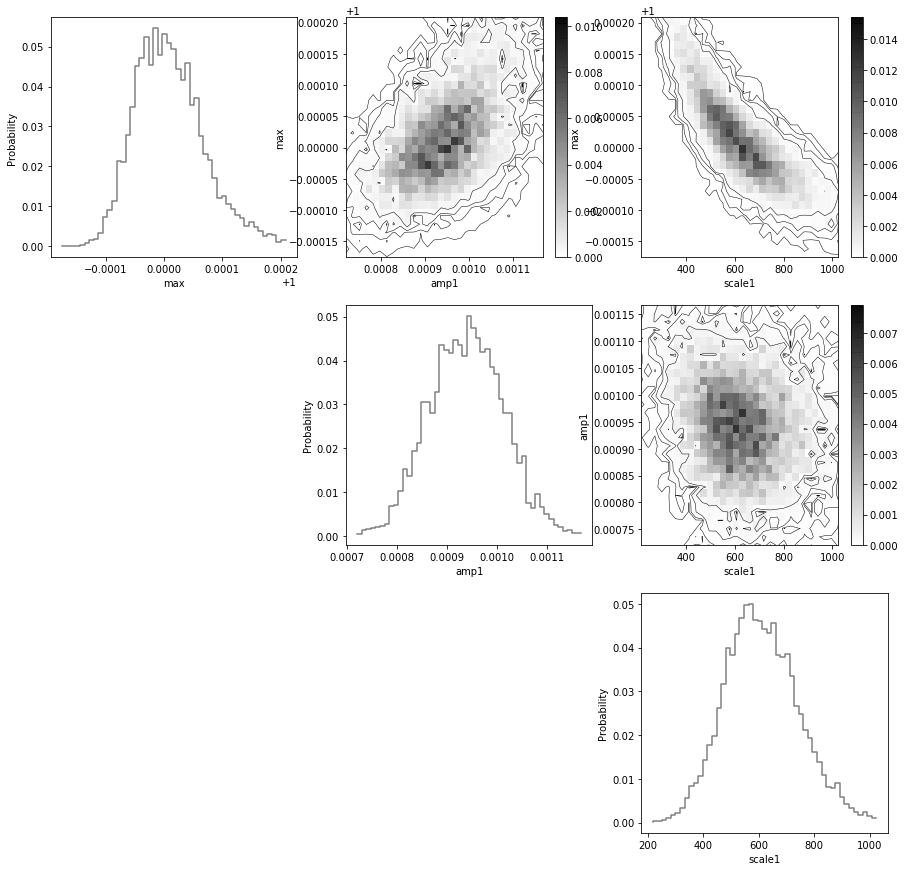

In [13]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p_SEM = pymultinest.PlotMarginalModes(a_SEM)
plt.figure(figsize=(5*n_params_SEM, 5*n_params_SEM))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params_SEM):
    plt.subplot(n_params_SEM, n_params_SEM, n_params_SEM * i + i + 1)
    p_SEM.plot_marginal(i, with_ellipses = False, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters_SEM[i])
    
    for j in range(i):
        plt.subplot(n_params_SEM, n_params_SEM, n_params_SEM * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p_SEM.plot_conditional(i, j, with_ellipses = False, with_points = False, grid_points=30)
        plt.xlabel(parameters_SEM[i])
        plt.ylabel(parameters_SEM[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

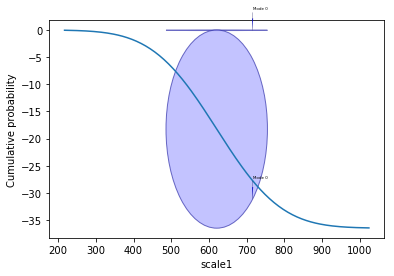

In [14]:
# plt.figure(figsize=(5*n_params, 5*n_params))
# plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params_SEM):
    # print(5*n_params, 1, i+1)
    plt.subplot(5*n_params_SEM, 1, i+1)
    p_SEM.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters_SEM[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p_SEM.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters_SEM[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

In [15]:
p_SEM.analyser.get_best_fit()['parameters'], [param0_SEM_init, param1_SEM_init, param2_SEM_init]

([1.0000133558171078, 0.00093740977947822941, 594.58262663516143],
 [1.0, 0.0012928309715467545, 839.0])

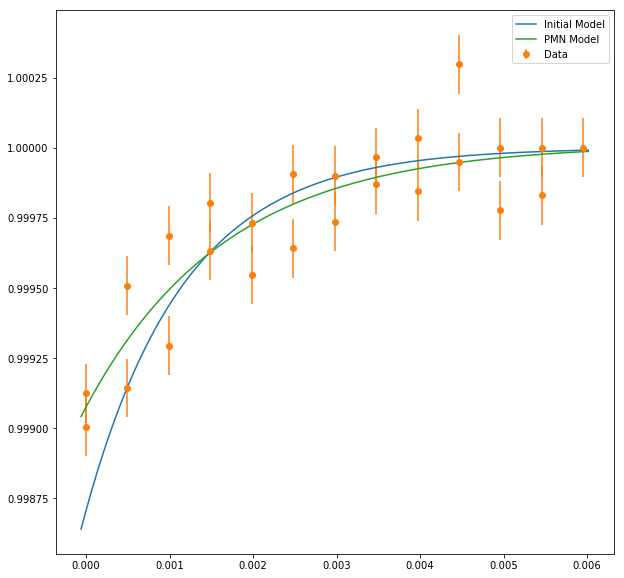

In [16]:
figure(figsize=(10,10))
plot(thdata_SEM, model_SEM([param0_SEM_init,param1_SEM_init, param2_SEM_init])(thdata_SEM), label='Initial Model')
errorbar(xdata, ydata, yuncs, fmt='o', label='Data')
plot(thdata_SEM, model_SEM(p_SEM.analyser.get_best_fit()['parameters'])(thdata_SEM), label='PMN Model')
legend(loc=0)

In [17]:
p_SEM.analyser.get_stats()

{'global evidence': -36.48569459714431,
 'global evidence error': 0.11640738545662238,
 'marginals': [{'1sigma': [0.9999566584522139, 1.0000737926198193],
   '2sigma': [0.999915129439487, 1.0001650119366448],
   '3sigma': [0.9998743706685363, 1.0003277351921729],
   '5sigma': [0.9998054850313853, 1.0004951046828687],
   'median': 1.0000094230255574,
   'q01%': 0.9999009007610844,
   'q10%': 0.9999439289851151,
   'q25%': 0.9999712404772415,
   'q75%': 1.0000514737735433,
   'q90%': 1.0002091475505328,
   'q99%': 1.0002091475505328,
   'sigma': 5.8567083802696374e-05},
  {'1sigma': [0.0008674200033183332, 0.0010183801613510724],
   '2sigma': [0.000804183517227431, 0.001090626378648769],
   '3sigma': [0.0007212452100154518, 0.0011856860226816864],
   '5sigma': [0.0005841366082589945, 0.0014113418873352354],
   'median': 0.0009446906198698361,
   'q01%': 0.0007726850137758216,
   'q10%': 0.0008486234176296772,
   'q25%': 0.0008929937888410922,
   'q75%': 0.0009945610856428452,
   'q90%': 

# Unrestricted Double Exponential Model

1.0 0.000646415485773 839.0 0.000646415485773 839.0


<Container object of 3 artists>

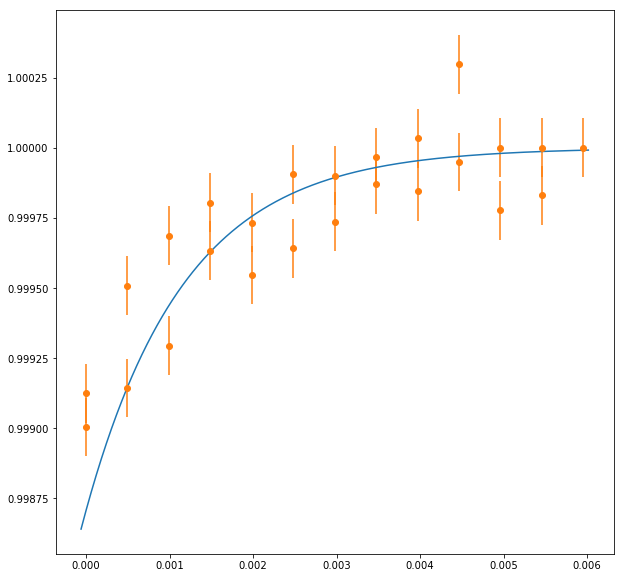

In [18]:
nThPts= int(1e3)
model_UDEM = double_exponential_model

xdata = test_data['DeltaPhase']
ydata = test_data['Flux']
yuncs = test_data['Sigma']

xmin, xmax = xdata.min(), xdata.max()
dx         = (xmax - xmin)/100
thdata_UDEM = np.linspace(xmin-dx, xmax+dx, nThPts)

param0_UDEM_init  = 1.0  # by defintion
param1_UDEM_init  = 0.5*(ydata.max() - ydata.min())#/100
param2_UDEM_init  = round(5/(xdata.max() - xdata.min()))
param3_UDEM_init  = 0.5*(ydata.max() - ydata.min())#/100
param4_UDEM_init  = round(5/(xdata.max() - xdata.min()))

print(param0_UDEM_init, param1_UDEM_init, param2_UDEM_init, param3_UDEM_init, param4_UDEM_init)

figure(figsize=(10,10))
plot(thdata_UDEM, model_UDEM([param0_UDEM_init,param1_UDEM_init,param2_UDEM_init, param3_UDEM_init, param4_UDEM_init])(thdata_UDEM))
errorbar(xdata, ydata, yuncs, fmt='o')

In [19]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave
# parameters = ["amp", "period"]

# model = straight_line
# parameters = ["offset", "slope"]

model_UDEM      = double_exponential_model
parameters_UDEM = ['max', 'amp1', 'scale1', 'amp2', 'scale2']

# def myprior_RDEM(cube, ndim, nparams):
#     cube[0] = cube[0] * 1e-3  + (1 - 1e-3/2)# - 10# U(0,2)
#     cube[1] = -cube[1] * 5e-3 + 5e-4 # - 10# U(0,1) -- default
#     cube[2] = cube[2] * 1e4   - 5e3# - 1000 # U(0,2000)
#     cube[3] = cube[3] * 5e-3  + 5e-4# - 10# U(0,1) -- default
#     cube[4] = cube[4] * 1e4   - 5e3# - 1000 # U(0,2000)

def myprior_UDEM(cube, ndim, nparams):
    cube[0] = cube[0] * 1e-2  + (1 - 1e-2/2)# - 10# U(0,2)
    cube[1] = cube[1] * 2     - 2/2 # - 10# U(0,1) -- default
    cube[2] = cube[2] * 1e4   - 1e4/2# - 1000 # U(0,2000)
    cube[3] = cube[3] * 2     - 2/2# - 10# U(0,1) -- default
    cube[4] = cube[4] * 1e4   - 1e4/2# - 1000 # U(0,2000)

def myloglike_UDEM(cube, ndim, nparams):
    modelNow = model_UDEM(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

Wrong number of columns at line 95
  analysing data from chains/HAT38-visit1-unrestricted_double_exponential_model-.txt
UDEM took 307.5915460586548 seconds


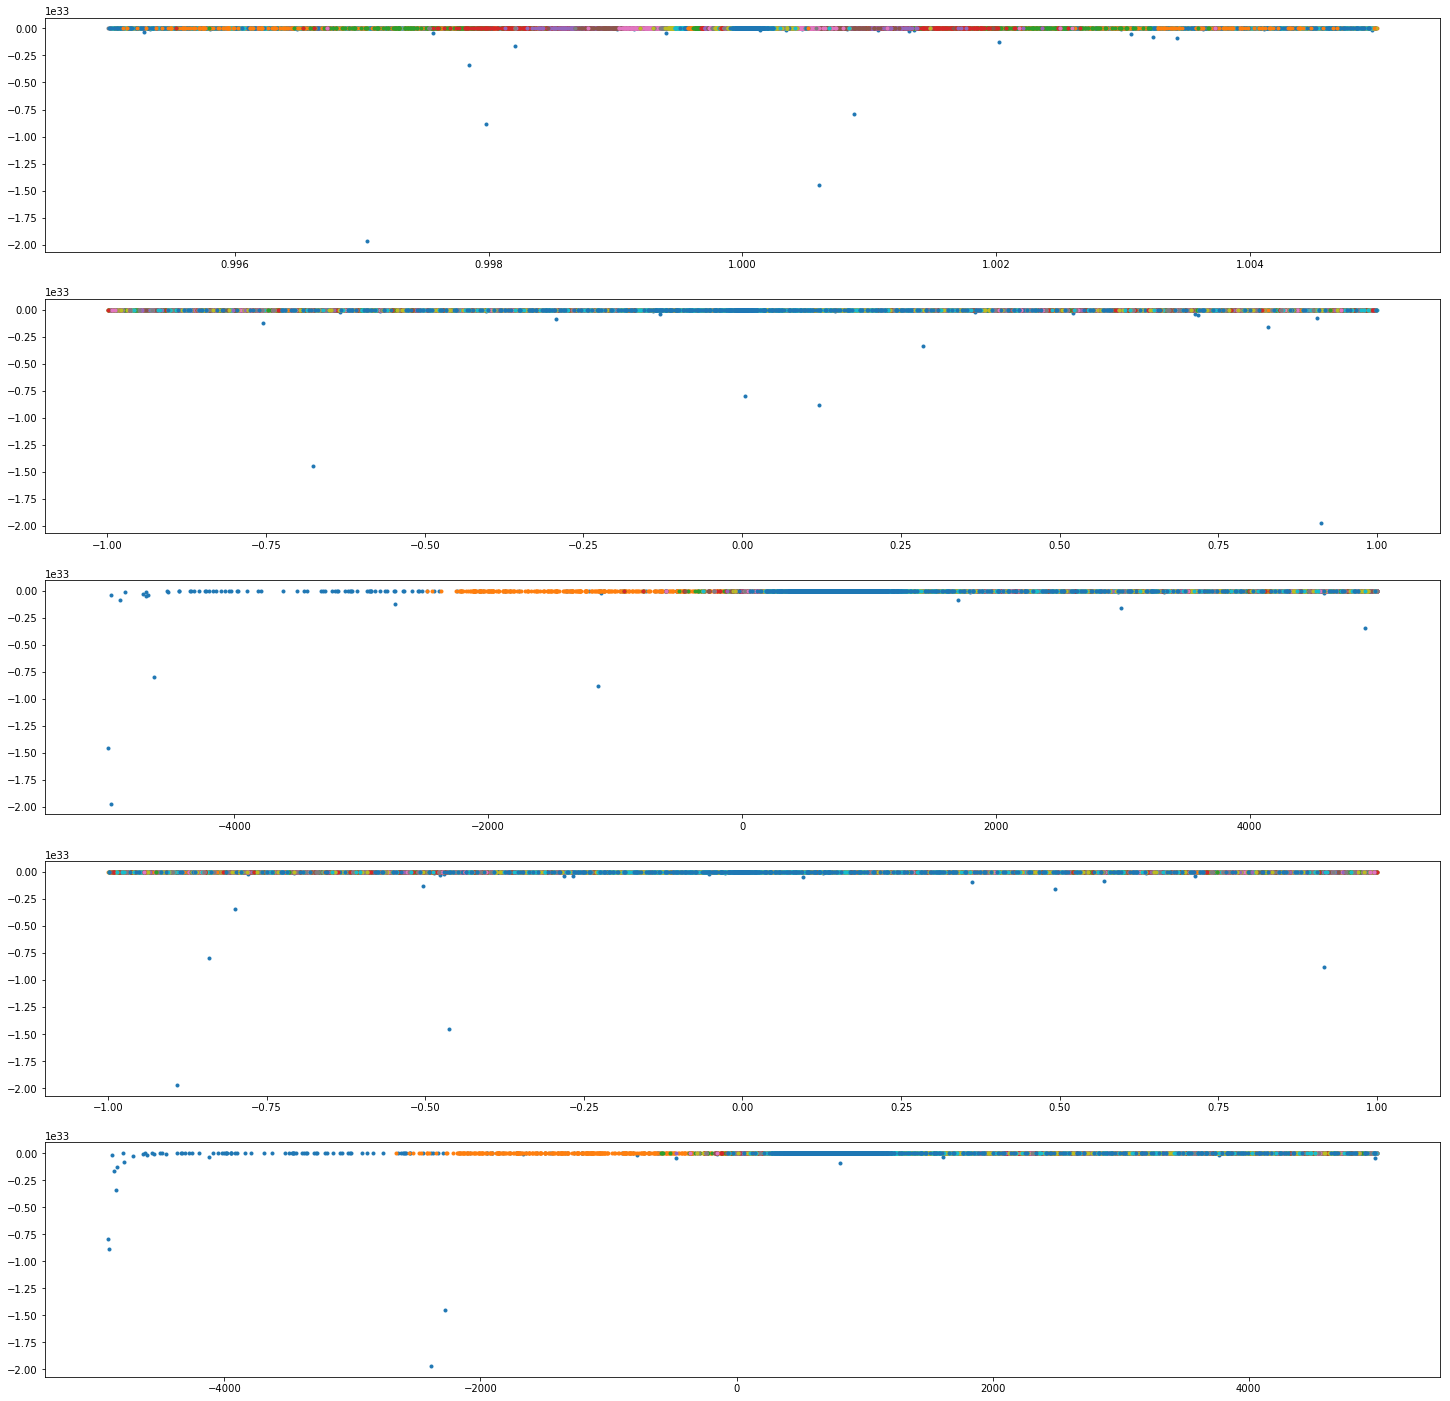

In [20]:
start = time()
# number of dimensions our problem has
# parameters = ["x", "y"]
n_params_UDEM = len(parameters_UDEM)

savedir              = 'chains'
planetName           = 'HAT38'
visitName            = 'visit1'
modelName            = 'unrestricted_double_exponential_model'
outputfiles_basename = savedir + '/' + planetName + '-' + visitName + '-' + modelName + '-'

plt.figure(figsize=(5*n_params_UDEM, 5*n_params_UDEM))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params_UDEM, outputfiles_basename=outputfiles_basename)
progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike_UDEM, myprior_UDEM, n_params_UDEM, importance_nested_sampling = False, resume = False, \
                verbose = True, sampling_efficiency = 'model', n_live_points = 1000, \
                outputfiles_basename=outputfiles_basename)

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a_UDEM = pymultinest.Analyzer(n_params = n_params_UDEM, outputfiles_basename=outputfiles_basename)
s_UDEM = a_UDEM.get_stats()
print('UDEM took', time() - start, 'seconds')

# fig = plt.gcf()
# axs = fig.get_axes()

# for ax in axs:
#     ax.set_ylim()
#     # ax.set_xscale("log", nonposx='clip')
#     # ax.set_yscale("log", nonposy='clip')

In [21]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a_UDEM.outputfiles_basename, 'w') as f:
    json.dump(parameters_UDEM, f, indent=2)
# store derived stats
with open('%sstats.json' % a_UDEM.outputfiles_basename, mode='w') as f:
    json.dump(s_UDEM, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\t%.15e +- %.15e" % ( s_UDEM['nested sampling global log-evidence'], \
                                               s_UDEM['nested sampling global log-evidence error'] ))


------------------------------ ANALYSIS ------------------------------
Global Evidence:	-4.562786254310487e+01 +- 1.496011262478312e-01


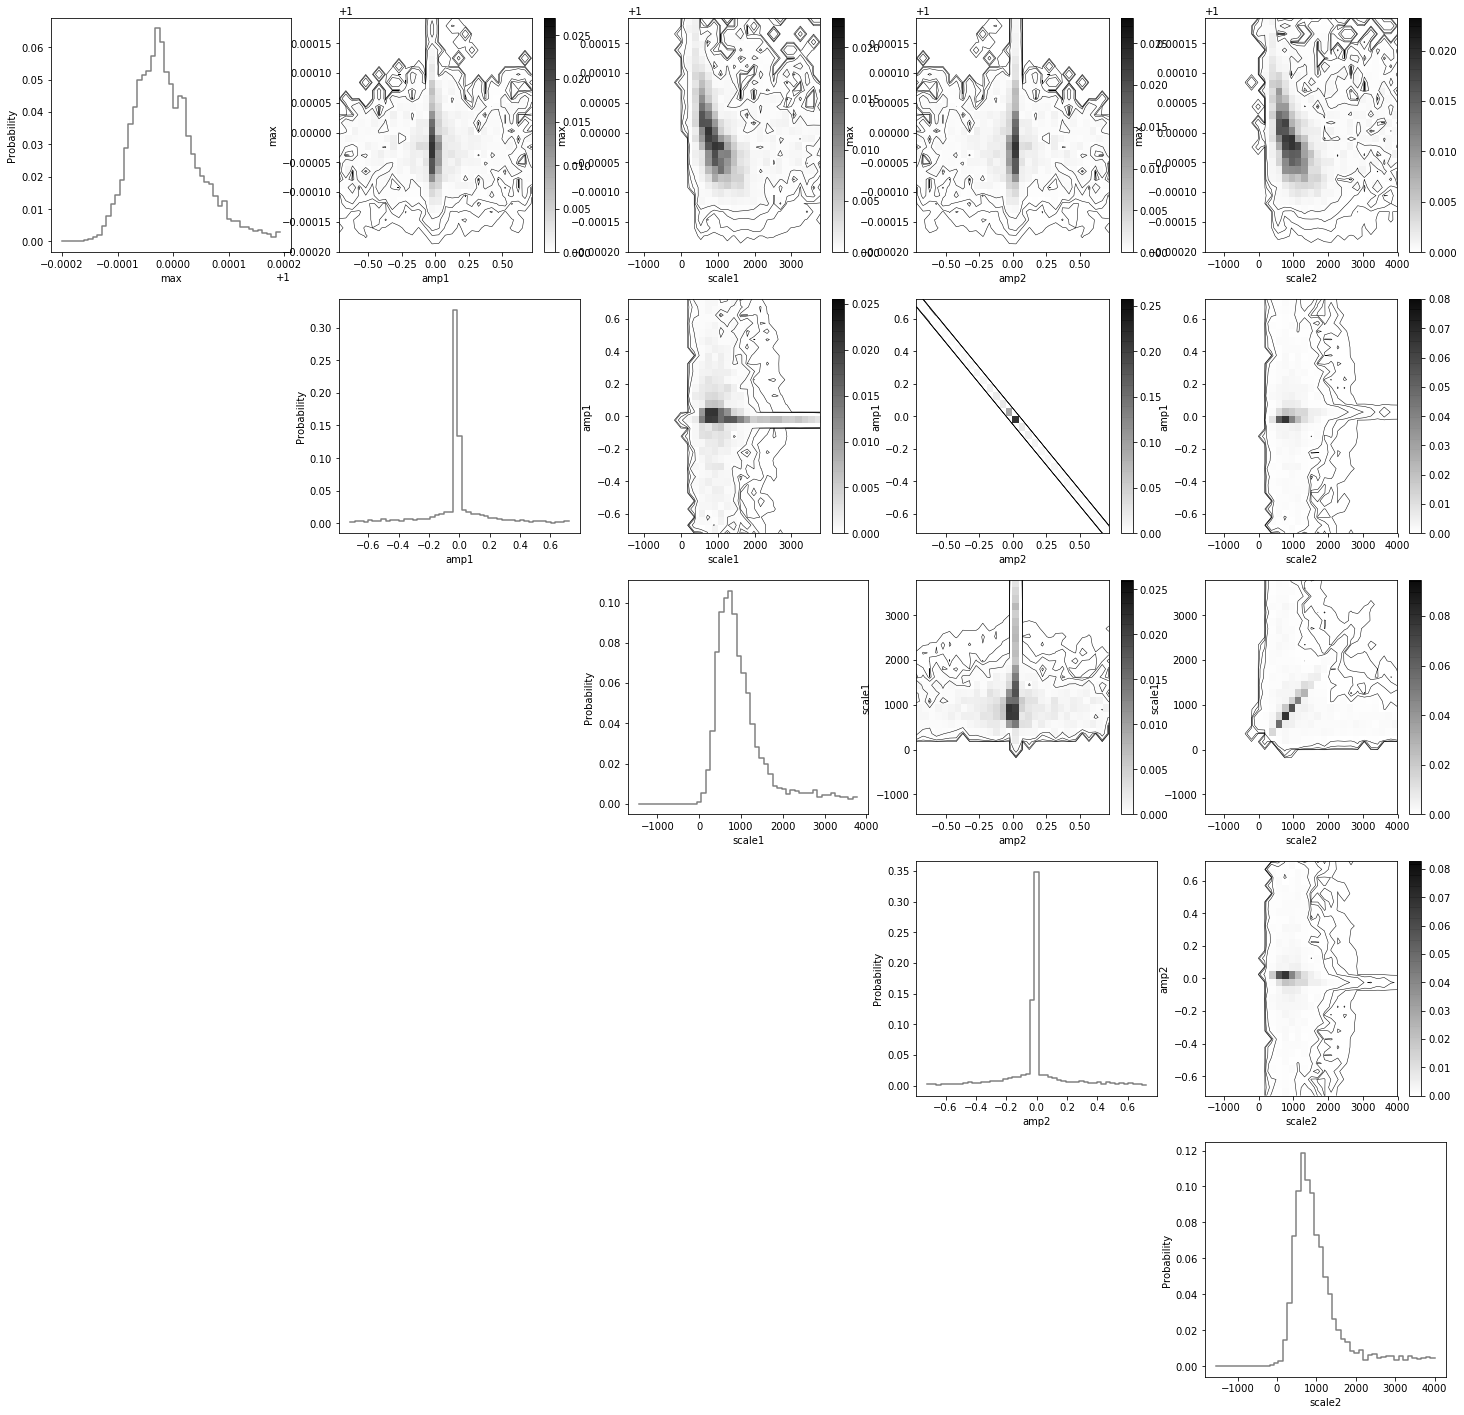

In [22]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p_UDEM = pymultinest.PlotMarginalModes(a_UDEM)
plt.figure(figsize=(5*n_params_UDEM, 5*n_params_UDEM))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params_UDEM):
    plt.subplot(n_params_UDEM, n_params_UDEM, n_params_UDEM * i + i + 1)
    p_UDEM.plot_marginal(i, with_ellipses = False, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters_UDEM[i])
    for j in range(i):
        plt.subplot(n_params_UDEM, n_params_UDEM, n_params_UDEM * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        # p_UDEM.plot_conditional(i, j, with_ellipses=False, with_points=False, grid_points=30)
        p_UDEM.plot_conditional(i, j, with_ellipses=False , with_points=False , grid_points=30, \
                                only_interpolate=False, use_log_values=False, marginalization_type='sum')
        plt.xlabel(parameters_UDEM[i])
        plt.ylabel(parameters_UDEM[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

In [23]:
axes_colors = rcParams['axes.prop_cycle'].by_key()['color']
nColors     = len(axes_colors)

In [24]:
minLogE, maxLogE = min(a_UDEM.get_equal_weighted_posterior().T[-1]), max(a_UDEM.get_equal_weighted_posterior().T[-1])
rangeLogE        = maxLogE - minLogE
minLogE, maxLogE, rangeLogE, nColors

(-32.1969429102719, -21.432585028769378, 10.764357881502523, 10)

(array([   22.,    36.,    51.,   175.,   144.,   313.,   488.,   820.,
         1971.,   597.,    39.]),
 array([-32.19694291, -29.04414577, -27.75760589, -26.99925358,
        -25.74798989, -25.22418748, -24.51574497, -23.80025072,
        -23.07520777, -21.94516751, -21.51091179, -21.43258503]),
 <a list of 11 Patch objects>)

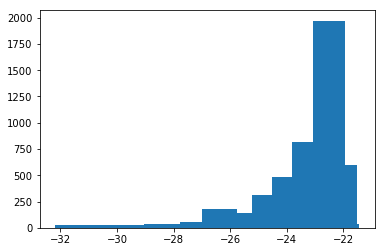

In [25]:
from astroML.plotting import hist
from statsmodels.robust import scale
hist(a_UDEM.get_equal_weighted_posterior().T[-1], bins='blocks')

In [26]:
nSig      = 10
mad_logE  = scale.mad(a_UDEM.get_equal_weighted_posterior().T[-1])
med_logE  = median(a_UDEM.get_equal_weighted_posterior().T[-1])

madBins   = [med_logE - nSig*mad_logE for nSig in range(nColors)]

In [ ]:
fig = figure(figsize=(15,15));

logEchain = a_UDEM.get_equal_weighted_posterior().T[-1]
mad_logE  = scale.mad(a_UDEM.get_equal_weighted_posterior().T[-1])
med_logE  = median(a_UDEM.get_equal_weighted_posterior().T[-1])

madBins   = [med_logE - nSig*mad_logE for nSig in range(nColors+1)]

for k in range(5):
    ax = fig.add_subplot(5,1,k+1);
    for nSig in range(nColors):
        for klogE in range(logEchain.size):
            if logEchain[klogE] > madBins[nSig] or logEchain[klogE] < madBins[nSig+1]:
                ax.plot(a_UDEM.get_equal_weighted_posterior().T[k],\
                        logEchain,'o', \
                        color = axes_colors[nSig], alpha=0.1);

fig.canvas.draw();

In [ ]:
# plt.figure(figsize=(5*n_params, 5*n_params))
# plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params_UDEM):
    # print(5*n_params, 1, i+1)
    plt.subplot(5*n_params_UDEM, 1, i+1)
    p_UDEM.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters_UDEM[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p_UDEM.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters_UDEM[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

In [ ]:
p_UDEM.analyser.get_best_fit()['parameters'], [param0_UDEM_init, param1_UDEM_init, param2_UDEM_init, param3_UDEM_init, param4_UDEM_init]

In [ ]:
figure(figsize=(10,10))
plot(thdata_UDEM, model_UDEM([param0_UDEM_init,param1_UDEM_init, param2_UDEM_init, param3_UDEM_init, param4_UDEM_init])(thdata_UDEM), label='Initial Model')
errorbar(xdata, ydata, yuncs, fmt='o', label='Data')
plot(thdata_UDEM, model_UDEM(p_UDEM.analyser.get_best_fit()['parameters'])(thdata_UDEM), label='PMN UDEM Model')
legend(loc=0)

In [ ]:
p_UDEM.analyser.get_stats()

# Restricted Double Exponential Model

In [ ]:
nThPts= int(1e3)
model_RDEM = double_exponential_model

xdata = test_data['DeltaPhase']
ydata = test_data['Flux']
yuncs = test_data['Sigma']

xmin, xmax = xdata.min(), xdata.max()
dx         = (xmax - xmin)/100
thdata_RDEM = np.linspace(xmin-dx, xmax+dx, nThPts)

param0_RDEM_init  = 1.0  # by defintion
param1_RDEM_init  = 0.5*(ydata.max() - ydata.min())#/100
param2_RDEM_init  = round(5/(xdata.max() - xdata.min()))
param3_RDEM_init  = 0.5*(ydata.max() - ydata.min())#/100
param4_RDEM_init  = round(5/(xdata.max() - xdata.min()))

print(param0_RDEM_init, param1_RDEM_init, param2_RDEM_init, param3_RDEM_init, param4_RDEM_init)

figure(figsize=(10,10))
plot(thdata_RDEM, model_RDEM([param0_RDEM_init,param1_RDEM_init,param2_RDEM_init, param3_RDEM_init, param4_RDEM_init])(thdata_RDEM))
errorbar(xdata, ydata, yuncs, fmt='o')

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave
# parameters = ["amp", "period"]

# model = straight_line
# parameters = ["offset", "slope"]

model_RDEM      = double_exponential_model
parameters_RDEM = ['max', 'amp1', 'scale1', 'amp2', 'scale2']

def myprior_RDEM(cube, ndim, nparams):
    cube[0] = cube[0] * 1e-3  + (1 - 1e-3/2)# - 10# U(0,2)
    cube[1] = -cube[1] * 5e-3 + 5e-4 # - 10# U(0,1) -- default
    cube[2] = cube[2] * 1e4   - 5e3# - 1000 # U(0,2000)
    cube[3] = cube[3] * 5e-3  + 5e-4# - 10# U(0,1) -- default
    cube[4] = cube[4] * 1e4   - 5e3# - 1000 # U(0,2000)

def myloglike_RDEM(cube, ndim, nparams):
    chi = 1.
    # print "cube", [cube[i] for i in range(ndim)], cube
    # for i in range(ndim):
    #     chi *= -0.5 * ((cube[i] - 0.2) / 0.1)**2#math.cos(cube[i] / 2.) * math.sin(cube[i] / 2.)
    # print "returning", math.pow(2. + chi, 5)
    modelNow = model_RDEM(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

In [ ]:
start = time()
# number of dimensions our problem has
# parameters = ["x", "y"]
n_params_RDEM = len(parameters_RDEM)

savedir              = 'chains'
planetName           = 'HAT38'
visitName            = 'visit1'
modelName            = 'restricted_double_exponential_model'
outputfiles_basename = savedir + '/' + planetName + '-' + visitName + '-' + modelName + '-'

plt.figure(figsize=(5*n_params_RDEM, 5*n_params_RDEM))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params_RDEM, outputfiles_basename=outputfiles_basename); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike_RDEM, myprior_RDEM, n_params_RDEM, importance_nested_sampling = False, resume = False, verbose = True, \
            sampling_efficiency = 'model', n_live_points = 1000, outputfiles_basename=outputfiles_basename)

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a_RDEM = pymultinest.Analyzer(n_params = n_params_RDEM, outputfiles_basename=outputfiles_basename)
s_RDEM = a_RDEM.get_stats()
print('RDEM took', time() - start, 'seconds')

# fig = plt.gcf()
# axs = fig.get_axes()

# for ax in axs:
#     ax.set_ylim()
#     # ax.set_xscale("log", nonposx='clip')
#     # ax.set_yscale("log", nonposy='clip')

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a_RDEM.outputfiles_basename, 'w') as f:
    json.dump(parameters_RDEM, f, indent=2)
# store derived stats
with open('%sstats.json' % a_RDEM.outputfiles_basename, mode='w') as f:
    json.dump(s_RDEM, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\t%.15e +- %.15e" % ( s_RDEM['nested sampling global log-evidence'], \
                                               s_RDEM['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p_RDEM = pymultinest.PlotMarginalModes(a_RDEM)
plt.figure(figsize=(5*n_params_RDEM, 5*n_params_RDEM))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params_RDEM):
    plt.subplot(n_params_RDEM, n_params_RDEM, n_params_RDEM * i + i + 1)
    p_RDEM.plot_marginal(i, with_ellipses = False, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters_RDEM[i])
    
    for j in range(i):
        plt.subplot(n_params_RDEM, n_params_RDEM, n_params_RDEM * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p_RDEM.plot_conditional(i, j, with_ellipses = False, with_points = False, grid_points=30)
        plt.xlabel(parameters_RDEM[i])
        plt.ylabel(parameters_RDEM[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

In [ ]:
# plt.figure(figsize=(5*n_params, 5*n_params))
# plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params_RDEM):
    # print(5*n_params, 1, i+1)
    plt.subplot(5*n_params_RDEM, 1, i+1)
    p_RDEM.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters_RDEM[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p_RDEM.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters_RDEM[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

In [ ]:
p_RDEM.analyser.get_best_fit()['parameters'], [param0_RDEM_init, param1_RDEM_init, param2_RDEM_init, param3_RDEM_init, param4_RDEM_init]

In [ ]:
figure(figsize=(10,10))
plot(thdata_RDEM, model_RDEM([param0_RDEM_init,param1_RDEM_init, param2_RDEM_init, param3_RDEM_init, param4_RDEM_init])(thdata_RDEM), label='Initial Model')
errorbar(xdata, ydata, yuncs, fmt='o', label='Data')
plot(thdata_RDEM, model_RDEM(p_RDEM.analyser.get_best_fit()['parameters'])(thdata_RDEM), label='PMN Model')
legend(loc=0)

In [ ]:
p_RDEM.analyser.get_stats()

# Compare Unrestricted Double, Restricted Double, and Single Exponential

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a_SEM.outputfiles_basename, 'w') as f:
    json.dump(parameters_SEM, f, indent=2)
# store derived stats
with open('%sstats.json' % a_SEM.outputfiles_basename, mode='w') as f:
    json.dump(s_SEM, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("SEM Global Evidence:\t\t%.3f +- %.3f" % ( s_SEM['nested sampling global log-evidence'], \
                                                   s_SEM['nested sampling global log-evidence error'] ))

# store name of parameters, always useful
with open('%sparams.json' % a_UDEM.outputfiles_basename, 'w') as f:
    json.dump(parameters_UDEM, f, indent=2)
# store derived stats
with open('%sstats.json' % a_UDEM.outputfiles_basename, mode='w') as f:
    json.dump(s_UDEM, f, indent=2)

# print()
# print("-" * 30, 'ANALYSIS', "-" * 30)
print("UDEM Global Evidence:\t\t%.3f +- %.3f" % ( s_UDEM['nested sampling global log-evidence'], \
                                                   s_UDEM['nested sampling global log-evidence error'] ))

# store name of parameters, always useful
with open('%sparams.json' % a_RDEM.outputfiles_basename, 'w') as f:
    json.dump(parameters_RDEM, f, indent=2)
# store derived stats
with open('%sstats.json' % a_RDEM.outputfiles_basename, mode='w') as f:
    json.dump(s_RDEM, f, indent=2)

# print()
# print("-" * 30, 'ANALYSIS', "-" * 30)
print("RDEM Global Evidence:\t\t%.3f +- %.3f" % ( s_RDEM['nested sampling global log-evidence'], \
                                                   s_RDEM['nested sampling global log-evidence error'] ))

figure(figsize=(10,10))
plot(thdata_UDEM, model_SEM([param0_SEM_init,param1_SEM_init, param2_SEM_init])(thdata_SEM), \
     '.', label='Initial SEM Model')
plot(thdata_UDEM, \
 model_RDEM([param0_RDEM_init,param1_RDEM_init, param2_RDEM_init, param3_RDEM_init, param4_RDEM_init])(thdata_RDEM), \
 '--', label='Initial DEM Model')
errorbar(xdata, ydata, yuncs, fmt='o', label='Data')
plot(thdata_SEM, model_SEM(p_SEM.analyser.get_best_fit()['parameters'])(thdata_SEM), label='PMN SEM Model')
plot(thdata_UDEM, model_UDEM(p_UDEM.analyser.get_best_fit()['parameters'])(thdata_UDEM), label='PMN UDEM Model')
plot(thdata_RDEM, model_RDEM(p_RDEM.analyser.get_best_fit()['parameters'])(thdata_RDEM), label='PMN RDEM Model')
legend(loc=0)

# Polynomials

In [ ]:
figure(figsize=(20,20))
from numpy.polynomial import polynomial
def time_polynomial(params):
    # modelOut = np.zeros(tdata.size)
    # for kc, coeff in enumerate(params):
    #     modelOut += coeff * tdata**kc
    if len(params):
        return lambda tdata: polynomial.polyval(tdata, params)
    else:
        return lambda tdata: zeros(tdata.size)

def orbital_polynomial(params):
    # modelOut = np.zeros(xdata.size)
    # for kc, coeff in enumerate(params):
    #     modelOut += coeff * xdata**kc
    # return modelOut
    if len(params):
        return lambda odata: polynomial.polyval(odata, params)
    else:
        return lambda odata: zeros(odata.size)

def wavelength_polynomial(params):
    # modelOut = np.zeros(ldata.size)
    # for kc, coeff in enumerate(params):
    #     modelOut += coeff * ldata**kc
    # return modelOut
    if len(params):
        return lambda ldata: polynomial.polyval(ldata, params)
    else:
        return lambda ldata: zeros(ldata.size)

def polynomial_model(params):
    params_list= list(params.copy())[::-1]
    timeParams  = array([params_list.pop() for _ in range(nTimeCoeffs)])
    orbitParams = array([params_list.pop() for _ in range(nOrbitCoeffs)])
    waveParams  = array([params_list.pop() for _ in range(nWaveCoeffs)])
    return lambda tdata, odata, ldata: time_polynomial(timeParams)(tdata)      + \
                                       orbital_polynomial(orbitParams)(odata)  + \
                                       wavelength_polynomial(waveParams)(ldata)

tdata, xdata, ldata = np.random.uniform(-10,10,(3,100))
tdata.sort()
xdata.sort()
ldata.sort()

# tdata, xdata, ldata = [np.linspace(-10,10,100) for _ in range(3)]
for nTimeCoeffs in range(4):
    for nOrbitCoeffs in range(4):
        for nWaveCoeffs in range(4):
            params = np.random.uniform(-20,20,nTimeCoeffs+nOrbitCoeffs+nWaveCoeffs)
            plot(tdata, polynomial_model(params)(tdata,xdata,ldata),'.', alpha=0.5, mew=0)
            plot(xdata, polynomial_model(params)(tdata,xdata,ldata),'.', alpha=0.5, mew=0)
            plot(ldata, polynomial_model(params)(tdata,xdata,ldata),'.', alpha=0.5, mew=0)

In [ ]:
nThPts= int(1e3)
model_Poly  = polynomial_model

xdata = test_data['DeltaPhase']
ydata = test_data['Flux']
yuncs = test_data['Sigma']

nTimeCoeffs     = 2
nOrbitCoeffs    = 3
nWaveCoeffs     = 0

h38PlanetPhase  = test_data_input_input['Phase']
h38HSTPhase     = test_data['DeltaPhase']

xmin, xmax = xdata.min(), xdata.max()
dx         = (xmax - xmin)/100
thdata_Poly = np.linspace(xmin-dx, xmax+dx, nThPts)

param0_Poly_init  = 1.0  # by defintion
param1_Poly_init  = 1.0
param2_Poly_init  = 1.0
param3_Poly_init  = 1.0
param4_Poly_init  = 1.0

print(param0_Poly_init, param1_Poly_init, param2_Poly_init, param3_Poly_init, param4_Poly_init)

figure(figsize=(10,10))
plot(thdata_Poly, model_Poly([param0_Poly_init,param1_Poly_init,param2_Poly_init, param3_Poly_init, param4_Poly_init])(thdata_Poly))
errorbar(xdata, ydata, yuncs, fmt='o')

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave
# parameters = ["amp", "period"]

# model = straight_line
# parameters = ["offset", "slope"]

nTimeCoeffs     = 2
nOrbitCoeffs    = 3
nWaveCoeffs     = 0

h38PlanetPhase  = test_data_input_input['Phase']
h38HSTPhase     = test_data['DeltaPhase']

model_Poly      = polynomial_model
parameters_Poly = ['timeIntercept', 'timeSlope', 'orbitIntercept', 'orbitSlope', 'orbitQuadratic']

cubeKWith = 1e3
def myprior_Poly(cube, ndim, nparams):
    for k in len(cube):
        cube[k] = cube[k] * cubeKWith - 0.5*cubeKWith

def myloglike_Poly(cube, ndim, nparams):
    chi = 1.
    # print "cube", [cube[i] for i in range(ndim)], cube
    # for i in range(ndim):
    #     chi *= -0.5 * ((cube[i] - 0.2) / 0.1)**2#math.cos(cube[i] / 2.) * math.sin(cube[i] / 2.)
    # print "returning", math.pow(2. + chi, 5)
    modelNow = model_Poly(cube)(times, HSTPhase, 0)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

In [ ]:
start = time()
# number of dimensions our problem has
# parameters = ["x", "y"]
n_params_Poly = len(parameters_Poly)

savedir              = 'chains'
planetName           = 'HAT38'
visitName            = 'visit1'
modelName            = 'polynomial_model'
outputfiles_basename = savedir + '/' + planetName + '-' + visitName + '-' + modelName + '-'

plt.figure(figsize=(5*n_params_Poly, 5*n_params_Poly))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params_Poly, outputfiles_basename=outputfiles_basename)

progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike_Poly, myprior_Poly, n_params_Poly, importance_nested_sampling = False, \
                resume = False, verbose = True, sampling_efficiency = 'model', n_live_points = 1000, \
                outputfiles_basename=outputfiles_basename)

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a_Poly = pymultinest.Analyzer(n_params = n_params_Poly, outputfiles_basename=outputfiles_basename)
s_Poly = a_Poly.get_stats()
print('Polynomial took', time() - start, 'seconds')

# fig = plt.gcf()
# axs = fig.get_axes()

# for ax in axs:
#     ax.set_ylim()
#     # ax.set_xscale("log", nonposx='clip')
#     # ax.set_yscale("log", nonposy='clip')

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a_RDEM.outputfiles_basename, 'w') as f:
    json.dump(parameters_RDEM, f, indent=2)
# store derived stats
with open('%sstats.json' % a_RDEM.outputfiles_basename, mode='w') as f:
    json.dump(s_RDEM, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\t%.15e +- %.15e" % ( s_RDEM['nested sampling global log-evidence'], \
                                               s_RDEM['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p_RDEM = pymultinest.PlotMarginalModes(a_RDEM)
plt.figure(figsize=(5*n_params_RDEM, 5*n_params_RDEM))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params_RDEM):
    plt.subplot(n_params_RDEM, n_params_RDEM, n_params_RDEM * i + i + 1)
    p_RDEM.plot_marginal(i, with_ellipses = False, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters_RDEM[i])
    
    for j in range(i):
        plt.subplot(n_params_RDEM, n_params_RDEM, n_params_RDEM * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p_RDEM.plot_conditional(i, j, with_ellipses = False, with_points = False, grid_points=30)
        plt.xlabel(parameters_RDEM[i])
        plt.ylabel(parameters_RDEM[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

In [ ]:
# plt.figure(figsize=(5*n_params, 5*n_params))
# plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params_RDEM):
    # print(5*n_params, 1, i+1)
    plt.subplot(5*n_params_RDEM, 1, i+1)
    p_RDEM.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters_RDEM[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p_RDEM.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters_RDEM[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

In [ ]:
p_RDEM.analyser.get_best_fit()['parameters'], [param0_RDEM_init, param1_RDEM_init, param2_RDEM_init, param3_RDEM_init, param4_RDEM_init]

In [ ]:
figure(figsize=(10,10))
plot(thdata_RDEM, model_RDEM([param0_RDEM_init,param1_RDEM_init, param2_RDEM_init, param3_RDEM_init, param4_RDEM_init])(thdata_RDEM), label='Initial Model')
errorbar(xdata, ydata, yuncs, fmt='o', label='Data')
plot(thdata_RDEM, model_RDEM(p_RDEM.analyser.get_best_fit()['parameters'])(thdata_RDEM), label='PMN Model')
legend(loc=0)

In [ ]:
p_RDEM.analyser.get_stats()